**Before Processing the signals, we will load them in from our dataset**

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.preprocessing import StandardScaler
import mne
import SignalProcessing.signalProcessing


mne.set_log_level('WARNING')  # Reduce log level to suppress unnecessary messages


def convert_eeg_vmrk_to_csv(vhdr_file: str, output_csv_file: str):
    """
    Convert BrainVision EEG data and event markers to CSV format with remapped column names.

    Parameters:
    vhdr_file (str): Path to the .vhdr file.
    output_csv_file (str): Path to the output CSV file.
    """
    if not vhdr_file.endswith('.vhdr'):
        raise ValueError("The input file must be a .vhdr file.")
    
    if not os.path.exists(vhdr_file):
        raise FileNotFoundError(f".vhdr file not found: {vhdr_file}")
    
    # Load the EEG data using the .vhdr file
    raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)
    
    # Get the data as a NumPy array
    data, times = raw.get_data(return_times=True)
    
    # Create a DataFrame for EEG data
    df_eeg = pd.DataFrame(data.T, columns=raw.ch_names)
    df_eeg['Time'] = times

    # Try to load events from the .vmrk file referenced by the .vhdr file
    try:
        events, event_ids = mne.events_from_annotations(raw)
        df_events = pd.DataFrame(events, columns=['Sample', 'Previous', 'EventID'])
        df_events['Time'] = df_events['Sample'] / raw.info['sfreq']
        df_events['State'] = df_events['EventID']
        df_events.drop(columns=['Sample', 'Previous', 'EventID'], inplace=True)  # Keep only time and state
    except ValueError as e:
        print(f"Warning: Could not extract annotations from {vhdr_file}: {str(e)}")
        df_events = pd.DataFrame(columns=['Time', 'State'])
    
    # Merge EEG data and events DataFrames on time using the nearest match
    df = pd.merge_asof(df_eeg, df_events, on='Time', direction='nearest')
    
    # Rename EEG columns to have consistent 'EEG {i}' naming
    eeg_columns = [f'EEG {i+1}' for i in range(len(raw.ch_names))]
    df.rename(columns=dict(zip(raw.ch_names, eeg_columns)), inplace=True)
    
    # Include only the necessary columns: EEG channels, Time, and State
    columns_to_include = eeg_columns + ['Time', 'State']
    df_filtered = df[columns_to_include]
    
    # Save the final DataFrame to a CSV file
    df_filtered.to_csv(output_csv_file, index=False)
    print(f"Data from {vhdr_file} has been converted and saved to {output_csv_file}")



In [2]:
from typing import List, Tuple
import numpy as np

def process_eeg(TIME_STEPS:int = 1200, included_states: List[str] =["Up", "Down", "Left", "Right", "Select"], subject_folder :str ='./NPYData/Subject_0')->Tuple[np.ndarray, np.ndarray]:
    """
        Process EEG data files from a specified subject folder and extract relevant EEG data segments.

        Parameters:
        TIME_STEPS (int): The number of time steps for each EEG data segment. Default is 1200.
        included_states (list): List of states to include in the processing. Default is ["Up", "Down", "Left", "Right", "Select"].
        subject_folder (str): Path to the folder containing EEG data files for the subject. Default is './NPYData/Subject_0'.

        Returns:
        tuple: A tuple containing:
            - X (np.ndarray): A NumPy array of shape (number of samples, number of EEG channels, TIME_STEPS) containing the processed EEG data.
            - Y (np.ndarray): A NumPy array of shape (number of samples,) containing the corresponding states for each EEG data segment.

        Notes:
        - The function reads CSV files from the specified subject folder.
        - Each CSV file is expected to contain columns 'EEG 1' to 'EEG 8' for EEG channels and 'State' for the state labels.
        - The function groups the EEG data by state transitions and extracts segments of length TIME_STEPS.
        - If a segment is shorter than TIME_STEPS, it is padded with zeros.
        - The function ensures that all extracted segments have the same shape.
        - If there are inconsistent shapes, the function filters out those segments and only retains the consistent ones.
    """

    files = os.listdir(subject_folder)
    subjectID = subject_folder.split('_')[-1]
    dfs = []
    # Read and process each file
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(subject_folder, file))
        elif file.endswith('.npy'):
            df = pd.DataFrame(np.load(os.path.join(subject_folder, file),allow_pickle=True)).rename({0:'EEG 1', 1:'EEG 2', 2:'EEG 3', 3:'EEG 4', 4:'EEG 5', 5:'EEG 6', 6:'EEG 7', 7:'EEG 8', 17:'State'}, axis=1)
        else:
            #Skipping non-CSV file
            continue
        df['Subject'] = subjectID
        dfs.append(df[['EEG 1', 'EEG 2', 'EEG 3', 'EEG 4', 'EEG 5', 'EEG 6', 'EEG 7', 'EEG 8', 'State', 'Subject']])

    # Process EEG data for each state
    all_state_data = []

    for df in dfs:
        state_groups = df.groupby((df['State'] != df['State'].shift()).cumsum())

        for _, data in state_groups:
            state = data['State'].iloc[0]
            if state in included_states:
                eeg_data = np.transpose(data[['EEG 1', 'EEG 2', 'EEG 3', 'EEG 4', 'EEG 5', 'EEG 6', 'EEG 7', 'EEG 8']].values)[:,:TIME_STEPS]
                # apply padding if timesteps are smaller than 1200
                if eeg_data.shape[1] < TIME_STEPS:
                    pad_width = TIME_STEPS - eeg_data.shape[1]
                    eeg_data = np.pad(eeg_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
                else:
                    eeg_data = eeg_data[:, :TIME_STEPS]

                all_state_data.append(pd.DataFrame({'State': [state], 'EEG Data': [eeg_data]}))

    # Concatenate the processed data
    final_df = pd.concat(all_state_data, ignore_index=True)

    # Fetch the list of arrays
    data_list = final_df['EEG Data'].values
    state_list = final_df['State'].values

    # Check the shapes of all arrays
    shapes = [arr.shape for arr in data_list]

    # Ensure all shapes are the same
    if len(set(shapes)) == 1:
        # All arrays have the same shape, so convert the list to a NumPy array
        X = np.array([item for item in data_list])
        Y = np.array([state for state in final_df['State'].values])
    else:
        # Print the shapes that are inconsistent
        print("Inconsistent shapes found:", set(shapes))
        # Filter and store only consistent shapes of data
        X = np.array([item for item in data_list if item.shape[1] == TIME_STEPS])
        Y = np.array([state for item, state in zip(data_list, state_list) if item.shape[1] == TIME_STEPS])

    X = X.astype('float64')

    return X, Y


In [3]:
csvFilesPath = "EEG Data/CSVFiles"
subfolders = [f.path for f in os.scandir(csvFilesPath) if f.is_dir()]
subfolders

#We iterate the subfolders and process the data
xVals = []
yVals = []
for folder in subfolders:
    x,y = process_eeg(subject_folder=folder)
    xVals.append(x)
    yVals.append(y)

In [4]:
for i in xVals:
    print(i.shape)

(375, 8, 1200)
(375, 8, 1200)
(350, 8, 1200)
(375, 8, 1200)
(350, 8, 1200)
(525, 8, 1200)
(375, 8, 1200)
(375, 8, 1200)
(375, 8, 1200)
(364, 8, 1200)
(375, 8, 1200)
(375, 8, 1200)


In [5]:
X = np.vstack(xVals)
X.shape


(4589, 8, 1200)

In [6]:
Y = np.hstack(yVals)
Y.shape

(4589,)

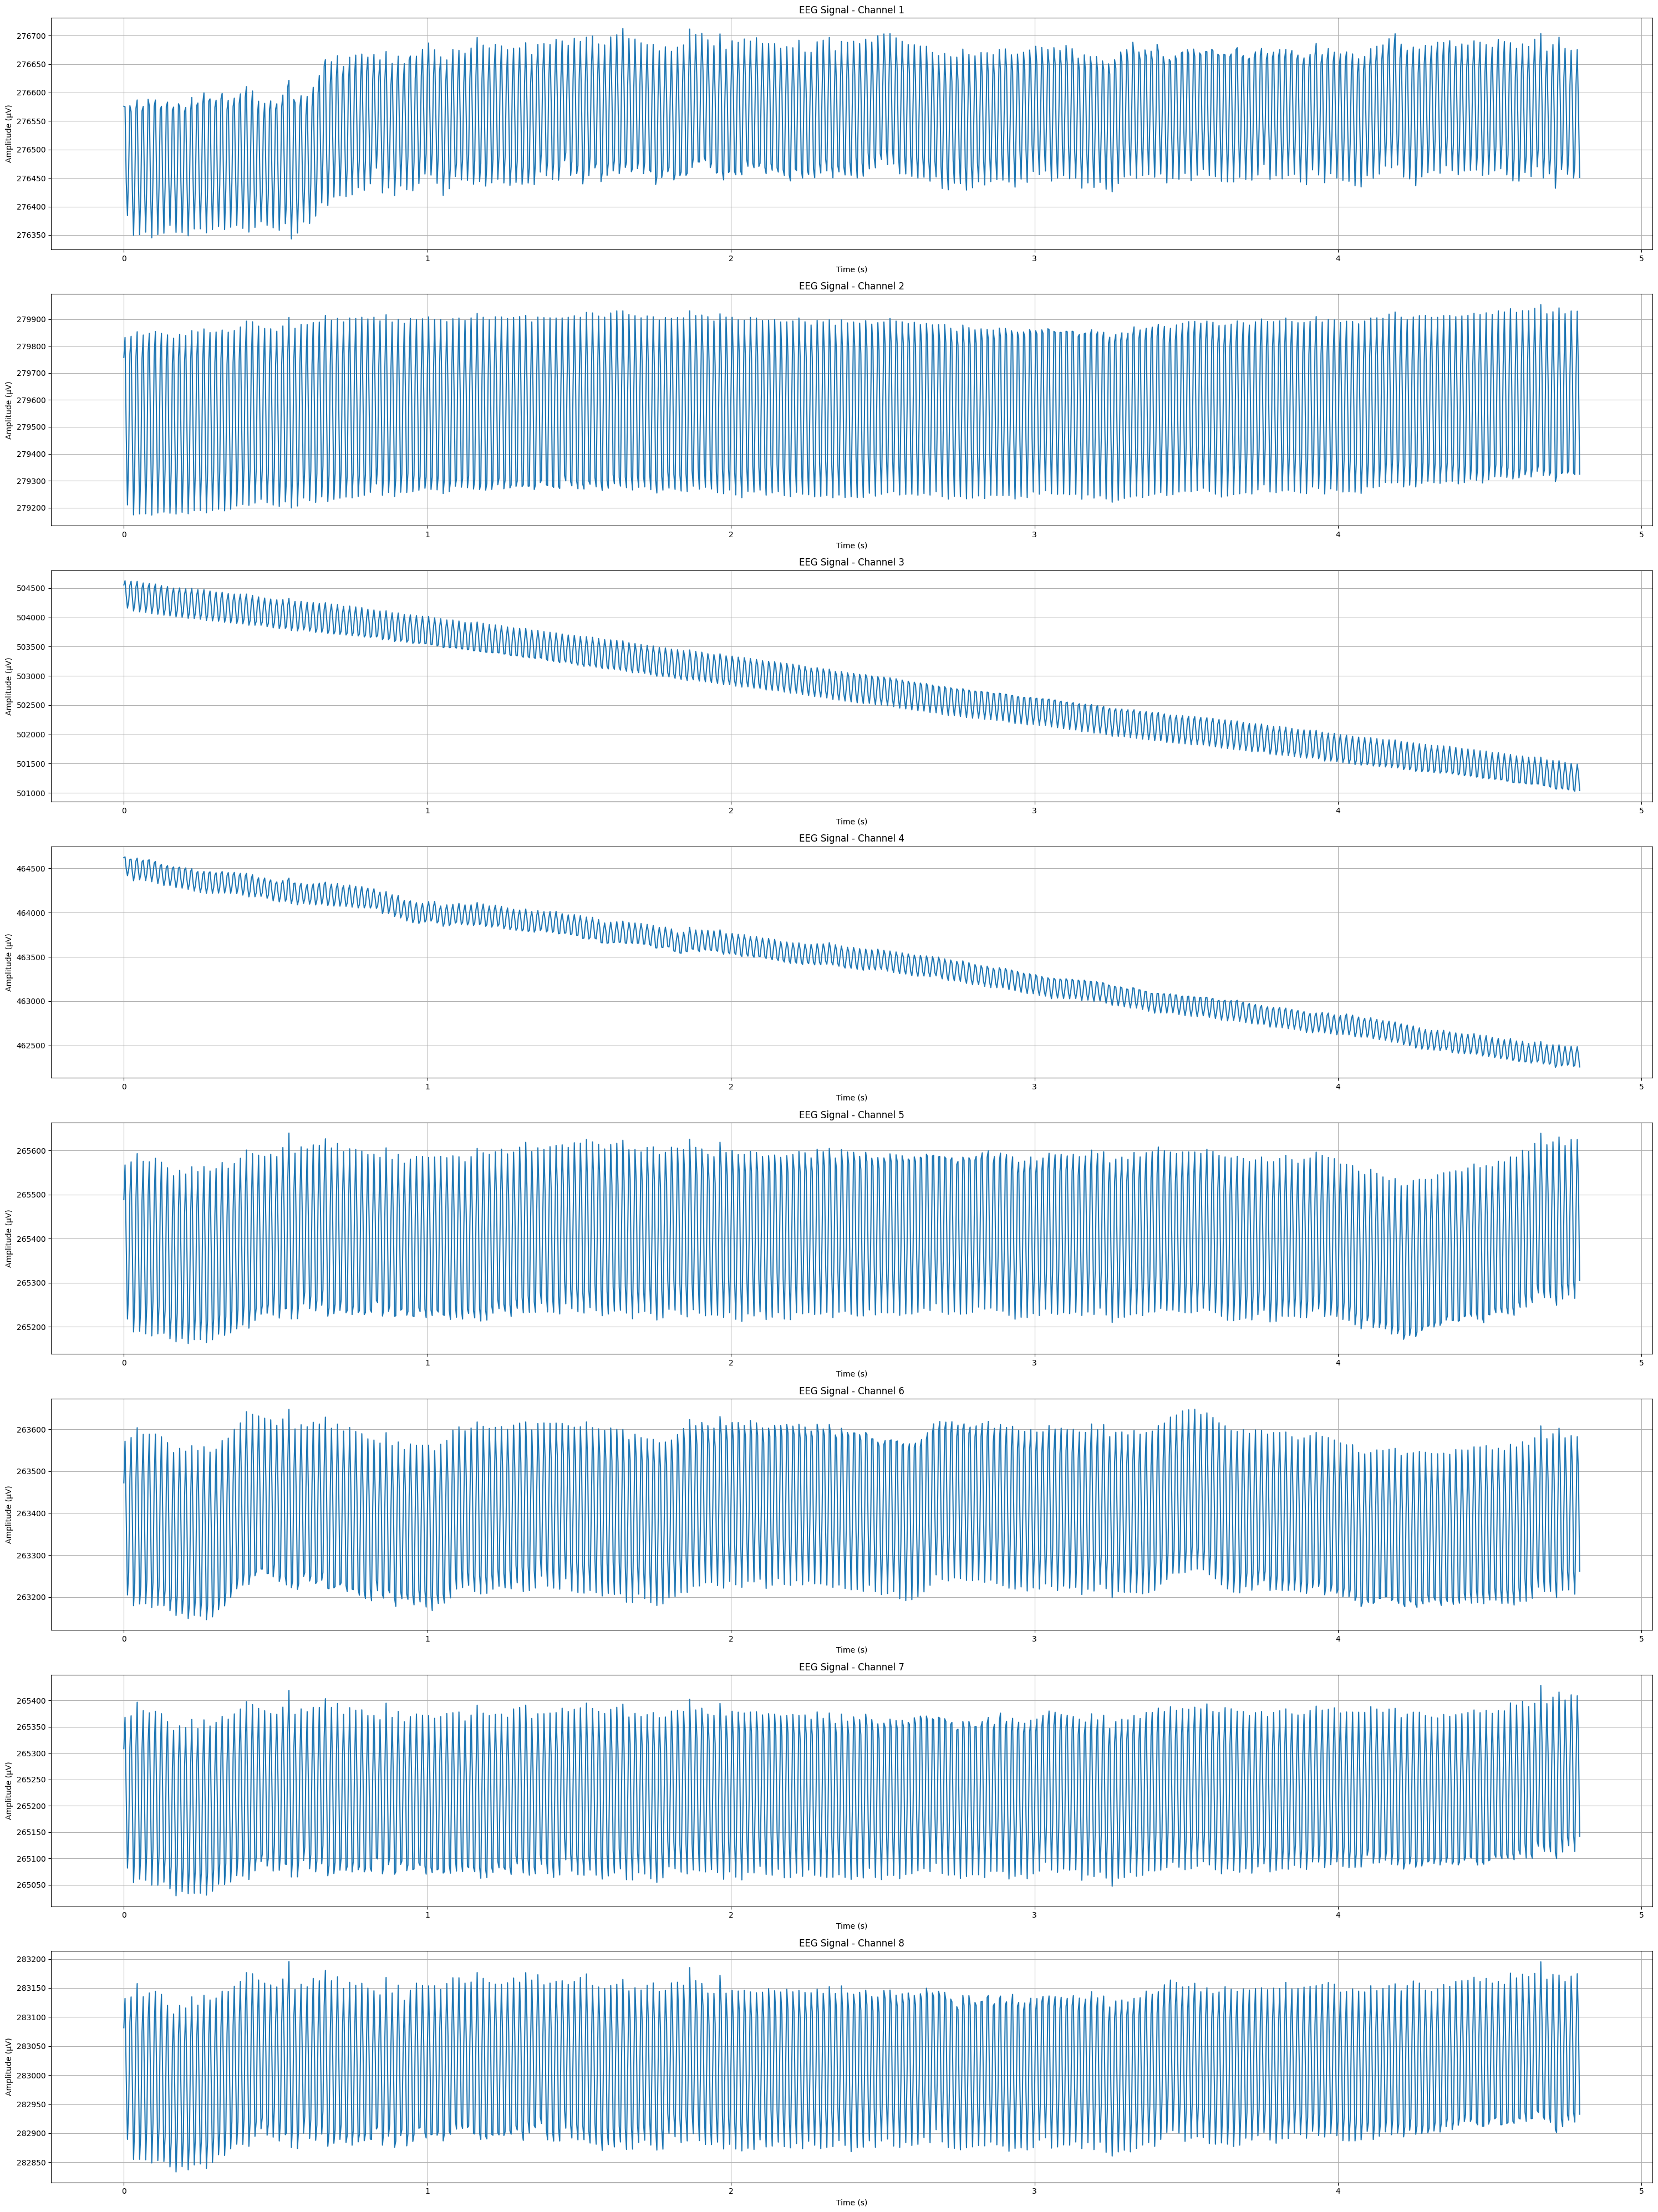

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plotEEGSignals(eegSignal):
        


    # Assuming X is the EEG data with shape (n_channels, n_samples)
    # Example: X.shape = (n_channels, n_samples)
    n_channels, n_samples = eegSignal.shape


    # # Time vector (assuming a sampling rate, you should adjust to your actual rate)
    sampling_rate = 250  # in Hz (adjust based on your data)
    time = np.arange(n_samples) / sampling_rate  # Time in seconds

    # # Plot the EEG signals for each channel
    plt.figure(figsize=(30, 40))

    for i in range(n_channels):
        plt.subplot(n_channels, 1, i + 1)  # Create subplots for each channel
        plt.plot(time, eegSignal[i, :], label=f'Channel {i + 1}')  # Plot each channel's data
        plt.title(f'EEG Signal - Channel {i + 1}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (µV)')
        plt.grid(True)

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()
    
    
plotEEGSignals(X[0])


In [8]:
asdadd

NameError: name 'asdadd' is not defined

We will apply some basic filters, first we will apply some notch and bandpass filters

In [10]:
#Applying bandpass filters


X = SignalProcessing.signalProcessing.filter_eeg(X)

# for i in range(len(X)):
#     for j in range(len(X[i])):
#         X[i][j] = SignalProcessing.signalProcessing.filter_eeg(X[i][j])


In [ ]:
asdasdsad

In [16]:
#Applying notch filters

for i in range(len(X)):
    for j in range(len(X[i])):
        X[i][j] = SignalProcessing.signalProcessing.notchFilter(X[i][j],50,30,250)

In [ ]:
plotEEGSignals(X[0])

In [ ]:
import sklearn
ica = sklearn.decomposition.FastICA(n_components=len(X[0]))

for i in range(len(X)):
    icaRes = SignalProcessing.signalProcessing.ica(X[i],ica)
    amplitudeCleanSignal = SignalProcessing.signalProcessing.amplitudeThresh(icaRes)
    
    icaClean = SignalProcessing.signalProcessing.powerBasedRejection(amplitudeCleanSignal)
    
    reconstructedSignal = ica.inverse_transform(icaClean.T).T
    
    X[i] = reconstructedSignal
    
    
    
    
    

In [11]:
X[0].shape

(8, 1200)

In [12]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(Y)
Y = to_categorical(y_int)



In [13]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,LSTM, Dropout, Bidirectional,Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN,BatchNormalization, TimeDistributed
from tensorflow.keras.datasets import reuters

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.callbacks import EarlyStopping



from sklearn.model_selection import train_test_split


In [14]:
print(f"X.shape: {X.shape}")
print(f"X[0].shape: {X[0].shape}")
type(X)

X.shape: (4589, 8, 1200)
X[0].shape: (8, 1200)


numpy.ndarray

In [18]:

model = Sequential()
# Add LSTM layer
model.add(LSTM(units=128, return_sequences=False,input_shape=X[0].shape))

# Dense layers
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       680,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 879,109 (3.35 MB)

 Trainable params: 879,109 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


TensorFlow version: 2.17.0
Keras version: 3.6.0


In [19]:
history = model.fit(X,Y,epochs=750,batch_size=512,validation_split=0.1)


Epoch 1/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1971 - loss: 0.6563 - val_accuracy: 0.1983 - val_loss: 0.5895
Epoch 2/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2082 - loss: 0.5664 - val_accuracy: 0.1917 - val_loss: 0.5161
Epoch 3/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2046 - loss: 0.5187 - val_accuracy: 0.1961 - val_loss: 0.5142
Epoch 4/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2234 - loss: 0.5048 - val_accuracy: 0.1939 - val_loss: 0.5067
Epoch 5/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2133 - loss: 0.5022 - val_accuracy: 0.1874 - val_loss: 0.5047
Epoch 6/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2141 - loss: 0.5007 - val_accuracy: 0.1983 - val_loss: 0.5120
Epoch 7/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2335 - loss: 0.4998 - val_accuracy: 0.1743 - val_loss: 0.5121
Epoch 8/750
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2282 - loss: 0.4983 - val_accuracy: 0.1830 - val_loss:

In [20]:
model.save('eegModel.h5')

In [1]:
import matplotlib.pyplot as plt



# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot training & validation accuracy values

# plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

<Figure size 1200x500 with 0 Axes>

In [ ]:
y_pred = model.predict(X)

In [ ]:
confusion_matrix(np.argmax(Y,axis=1),np.argmax(y_pred,axis=1))

In [22]:
label_encoder.classes_
import pickle

# Assuming label_encoder is your fitted LabelEncoder object
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [24]:
np.save('X.npy', X)


In [27]:
label_encoder.classes_[0]

'Down'